In [1]:
# Importing libraries
import pandas as pd
import streamlit as st
import seaborn as sns
import matplotlib.pyplot as plt

# Loading of Excel file
excel_file = pd.read_excel('data_source/Twisto_data.xlsx', sheet_name=None)

In [2]:
# Extracting of individual DataFrames
df_base = excel_file['profile_base']
df_customer = excel_file['profile_customer']
df_extension = excel_file['profile_extension']
df_apps = excel_file['profile_apps']
df_transactions = excel_file['profile_transactions']

In [3]:
# Filling in all empty values in df_transaction (column: category)
df_transactions['category'] = df_transactions['category'].fillna('Unknown')

In [4]:
# Count unique users with iOS app
ios_users = df_apps.loc[df_apps['app_ios'] != 0, 'user'].nunique()

# Count unique users with Android app
android_users = df_apps.loc[df_apps['app_android'] != 0, 'user'].nunique()

# Count unique users with neither app
unknown_users = df_apps.loc[
    (df_apps['app_ios'] == 0) & (df_apps['app_android'] == 0),
    'user'
].nunique()

print("iOS:", ios_users)
print("Android:", android_users)
print("Unknown:", unknown_users)

iOS: 292
Android: 314
Unknown: 427


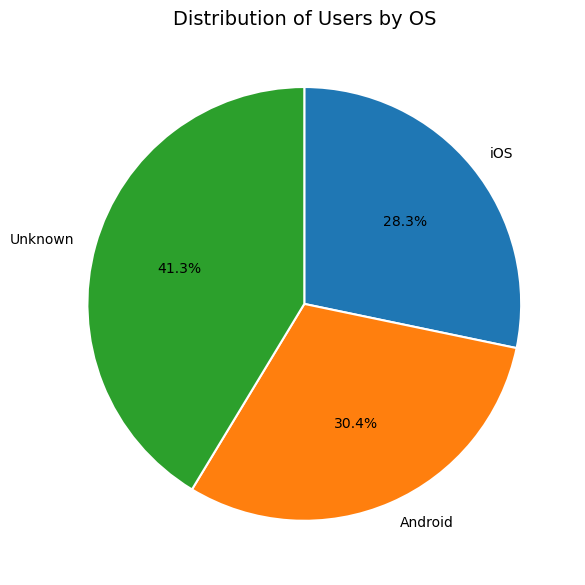

In [5]:
%matplotlib inline
# Create dictionary of counts
os_counts_overlap = {
    'iOS': ios_users,
    'Android': android_users,
    'Unknown': unknown_users
}

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    os_counts_overlap.values(), 
    labels=os_counts_overlap.keys(), 
    autopct='%1.1f%%', 
    startangle=90, 
    counterclock=False,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)
plt.title("Distribution of Users by OS", fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
def classify_os(row):
    ios = row['app_ios'] != 0
    android = row['app_android'] != 0
    
    if ios and android:
        return 'Both'
    elif ios:
        return 'iOS'
    elif android:
        return 'Android'
    else:
        return 'Unknown'

df_apps['os_type'] = df_apps.apply(classify_os, axis=1)

# Merging of df_apps and df_transactions
df_trans_platform = df_transactions.merge(
    df_apps[['user', 'os_type', 'app_ios', 'app_android']],
    on='user',
    how='left'
)

In [7]:
# iOS transactions
ios_trans = df_trans_platform.loc[df_trans_platform['user'].isin(
    df_apps.loc[df_apps['app_ios'] != 0, 'user']
)]
ios_stats = {
    'Avg Transactions': ios_trans.groupby('user').size().mean(),
    'Total Amount': ios_trans['total_price_vat'].sum(),
    'Avg Amount': ios_trans['total_price_vat'].mean()
}

# Android transactions
android_trans = df_trans_platform.loc[df_trans_platform['user'].isin(
    df_apps.loc[df_apps['app_android'] != 0, 'user']
)]
android_stats = {
    'Avg Transactions': android_trans.groupby('user').size().mean(),
    'Total Amount': android_trans['total_price_vat'].sum(),
    'Avg Amount': android_trans['total_price_vat'].mean()
}

# Unknown transactions
unknown_trans = df_trans_platform.loc[df_trans_platform['user'].isin(
    df_apps.loc[(df_apps['app_ios'] == 0) & (df_apps['app_android'] == 0), 'user']
)]
unknown_stats = {
    'Avg Transactions': unknown_trans.groupby('user').size().mean(),
    'Total Amount': unknown_trans['total_price_vat'].sum(),
    'Avg Amount': unknown_trans['total_price_vat'].mean()
}

# Combine into one DataFrame
summary_table = pd.DataFrame.from_dict({
    'iOS': ios_stats,
    'Android': android_stats,
    'Unknown': unknown_stats
}, orient='index')

# Format numbers
summary_table_formatted = summary_table.copy()
summary_table_formatted['Total Amount'] = summary_table_formatted['Total Amount'].map('{:,.0f} czk'.format)
summary_table_formatted['Avg Amount'] = summary_table_formatted['Avg Amount'].map('{:,.2f} czk'.format)
summary_table_formatted['Avg Transactions'] = summary_table_formatted['Avg Transactions'].map('{:.1f}'.format)

summary_table_formatted

,Avg Transactions,Total Amount,Avg Amount
iOS,139.6,"15,502,775 czk",451.28 czk
Android,105.9,"19,935,693 czk",658.16 czk
Unknown,29.2,"5,766,722 czk",610.56 czk


In [8]:
user_os_map = {}

# iOS users
ios_users = df_apps.loc[df_apps['app_ios'] != 0, 'user'].unique()
user_os_map.update({user: 'iOS' for user in ios_users})

# Android users
android_users = df_apps.loc[df_apps['app_android'] != 0, 'user'].unique()
user_os_map.update({user: 'Android' for user in android_users})

# Unknown users
unknown_users = df_apps.loc[
    (df_apps['app_ios'] == 0) & (df_apps['app_android'] == 0),
    'user'
].unique()
user_os_map.update({user: 'Unknown' for user in unknown_users})

In [9]:
df_trans_platform = df_transactions.copy()
df_trans_platform['os_type'] = df_trans_platform['user'].map(user_os_map).fillna('Unknown')

category_counts = (
    df_trans_platform.groupby(['os_type', 'category'])
    .size()
    .unstack(fill_value=0)
)

print(category_counts)

category  Beauty  Bills And Household   Car  Children  Culture  \
os_type                                                          
Android       88                   30  1587        78      137   
Unknown        6                    4   352        12       21   
iOS           93                   28  2478        85      144   

category  Digital Services  Drugstore  Electronics  Fashion  \
os_type                                                       
Android                951        521          156      631   
Unknown                 86        101           13      111   
iOS                    776        483          149      540   

category  Financial Services  ...  kancelar  knihy  moda  obchodni-dum  \
os_type                       ...                                        
Android                   80  ...         3     79   288            33   
Unknown                    4  ...         5    157   276            25   
iOS                       28  ...         2     31    51 

In [10]:
# Top 10 categories by revenue
top10_revenue = (
    df_transactions.groupby('category')['total_price_vat']
    .sum()
    .sort_values(ascending=False)
    .head(9)
    .index
)

# Top 10 categories by transaction count
top10_count = (
    df_transactions['category']
    .value_counts()
    .head(9)
    .index
)

# Union of both sets so we cover both
top_categories = set(top10_revenue).union(set(top10_count))

In [11]:
# Prepare filtered transaction table for top categories
df_top = df_trans_platform[df_trans_platform['category'].isin(top_categories)]

stats_list = []

for os_name in os_counts_overlap.keys():
    if os_name == 'iOS':
        users = df_apps.loc[df_apps['app_ios'] != 0, 'user']
    elif os_name == 'Android':
        users = df_apps.loc[df_apps['app_android'] != 0, 'user']
    else:  # Unknown
        users = df_apps.loc[(df_apps['app_ios'] == 0) & (df_apps['app_android'] == 0), 'user']

    # Filter transactions for these users
    os_trans = df_top[df_top['user'].isin(users)]

    # Aggregate stats per category
    stats_per_category = os_trans.groupby('category').agg(
        total_revenue=('total_price_vat', 'sum'),
        transaction_count=('total_price_vat', 'count'),
        avg_transaction_value=('total_price_vat', 'mean')
    ).reset_index()

    stats_per_category['os'] = os_name
    stats_list.append(stats_per_category)

# Combine all OS stats into one DataFrame
category_stats = pd.concat(stats_list, ignore_index=True)

category_stats

,category,total_revenue,transaction_count,avg_transaction_value,os
0,Car,1197960.74,2976,402.540571,iOS
1,Digital Services,310447.72,971,319.719588,iOS
2,Fashion,589805.58,674,875.082463,iOS
3,Food And Drink,870777.50,4205,207.081451,iOS
4,Groceries,1953154.35,7615,256.487768,iOS
5,Shopping Online,1003656.25,1575,637.242063,iOS
6,Travel,710552.90,1404,506.091809,iOS
7,Unknown,5317499.14,9133,582.229184,iOS
8,potraviny,850850.54,2028,419.551548,iOS
9,slevovy-portal,189247.00,303,624.577558,iOS


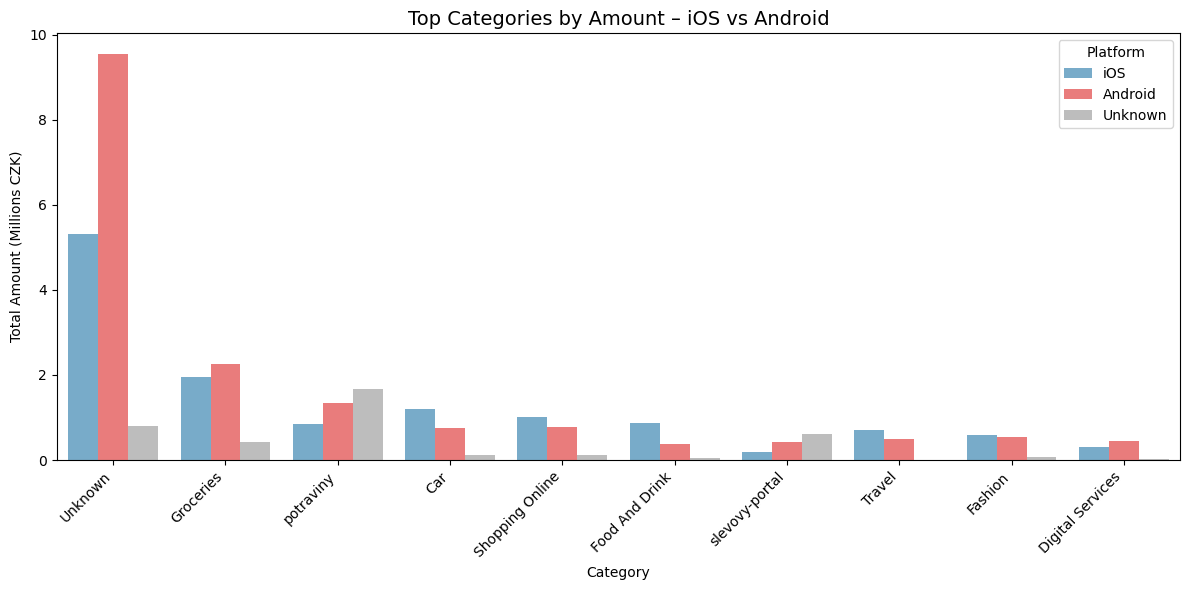

In [12]:
import matplotlib.ticker as mtick

# Define custom colors
colors = ['#6baed6', '#fb6a6a', '#bdbdbd']  # blue, red, gray

# Sort categories by total revenue (all platforms combined)
order = (
    category_stats.groupby('category')['total_revenue']
    .sum()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=category_stats,
    x='category', 
    y='total_revenue', 
    hue='os',
    order=order,
    palette=colors
)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.ylabel('Total Amount (Millions CZK)')
plt.xlabel('Category')
plt.title('Top Categories by Amount – iOS vs Android', fontsize=14)

def millions(x, pos):
    return f'{x*1e-6:,.0f}'

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(millions))

plt.legend(title='Platform')
plt.tight_layout()
plt.show()